NTK** applied to double descent

- use mnist1d dataset (Pytorch loader)
- build MLP using JAX
- use JAX grad, or linearize (or neural tangents linearize)
- compare vanilla MLP to linearized MLP during double descent


- Linearization is done for update function, but then optimizer is acting on it... need to check

In [ ]:
   # Activate your environment
   conda activate ntk_jax
   
   # Install ipykernel
   pip install ipykernel
   
   # Register the kernel
   python -m ipykernel install --user --name=ntk_jax

## Data loading

In [ ]:
# Run this if you're in a Colab
!git clone https://github.com/greydanus/mnist1d

Cloning into 'mnist1d'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 155 (delta 52), reused 123 (delta 26), pack-reused 0
Receiving objects: 100% (155/155), 6.48 MiB | 22.11 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [ ]:
pip list | grep jax

jax                              0.4.13
jaxlib                           0.4.13+cuda11.cudnn86
tf2jax                           0.3.5


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-44ca2220-2955-b158-a051-1820fbeefbfc)


In [ ]:
# We need at least jaxlib-0.1.73 to avoid certain CUDA bugs when using `implementation=auto`
!pip install -q --upgrade pip
!pip install -q jax[cuda11_cudnn82] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -q git+https://www.github.com/google/neural-tangents

  Preparing metadata (setup.py) ... done


In [ ]:
from jax import jit
from jax import numpy as np
from jax import random

import neural_tangents as nt
from neural_tangents import stax

In [ ]:
# !pip uninstall numpy
# !pip install numpy==1.23.5

In [ ]:
import mnist1d

from google.colab import drive




import jax
import neural_tangents as nt
from jax import jit
from jax import numpy as np
from jax import random


from neural_tangents import stax


from jax.nn import log_softmax, softmax
from jax.example_libraries import optimizers

from jax import grad, jit, vmap, value_and_grad, pmap
from jax import random

import tensorflow_datasets as tfds

import pandas as pd
import os
import numpy as onp
import matplotlib.pyplot as plt
import jax.numpy as jnp


from jax import make_jaxpr
from jax.config import config
from jax.example_libraries.stax import (
    Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax, BatchNorm
)

import numpy.random as npr
import itertools


onp.random.seed(1234)
%config IPCompleter.use_jedi = False


drive.mount('/content/gdrive')
project_dir = "/content/gdrive/My Drive/Research/mnist1d/"





ModuleNotFoundError: ignored


The dynamics of overfitting and generalization are very susceptible to the number of samples in the dataset. For the purposes of this experiment we'll use a dataset with 20k training examples.

In [ ]:
args = mnist1d.get_dataset_args()
args.num_samples = 12500
args.train_split = 0.8
data = mnist1d.get_dataset(args=args, download=False, regenerate=True)

print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each input: {}".format(data['x'].shape[-1]))
print("Number of classes: {}".format(len(data['templates']['y'])))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 10000
Examples in test set: 2500
Length of each input: 40
Number of classes: 10


In [ ]:
import copy

orig_labels = data['y']

def add_label_noise(labels, noise_level=0.10):
    # Determine the number of labels to change
    num_noisy_labels = int(noise_level * len(labels))

    # Randomly choose indices of labels to change
    noisy_indices = onp.random.choice(len(labels), num_noisy_labels, replace=False)


    # Create a copy of the labels to avoid changing the original array

    noisy_labels = copy.deepcopy(labels)

    # Change the selected labels
    for idx in noisy_indices:
        # Choose a new label that is different from the current one
        # Assuming the labels are integers starting from 0
        possible_new_labels = [label for label in range(labels.max() + 1) if label != noisy_labels[idx]]
        new_label = onp.random.choice(possible_new_labels)

        # Assign the new label
        noisy_labels[idx] = new_label

    return noisy_labels

# Example usage
label_noise = 0.15
data['y'] = add_label_noise(data['y'], noise_level=label_noise)

In [ ]:
data

NameError: ignored



According to the [deep double descent paper](https://www.pnas.org/content/116/32/15849) by Belkin et al., the interpolation threshold of a machine learning model lies at $n * K$ parameters where $n$ is the number of examples in the dataset and $K$ is the number of outputs in the model. So on a dataset with 10k training samples and 10 output classes, we would expect a model with 100k parameters to lie at the interpolation threshold.

**Loss functions matter.** Unlike the Belkin paper, which used a mean square error (MSE) loss to train the neural network model, we'll train our model with a negative log likelihood (NLL) loss. When using a NLL loss function, a model only needs to memorize _one_ output out of the $K$ total outputs, since it can make this label very large and the softmax will force all other logits to be small. So the interpolation threshold for our model should lie at $n*1=10,000$ parameters. Let's see if empirical results agree.

##pure JAX



In [ ]:

def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return onp.array(x[:, None] == onp.arange(k), dtype)

def loss_fn(params, batch_data):
    """Implements cross-entropy loss function.

    Args:
        params: Parameters of the network
        batch_data: A batch of data (images and labels)
    Returns:
        Loss calculated for the current batch
    """
    inputs, targets = batch_data
    preds = nn_apply(params, inputs)
    return -jnp.mean(jnp.sum(log_softmax(preds) * targets, axis=1))

def lin_loss_fn(lin_params, batch_data):
    """Implements cross-entropy loss function.

    Args:
        params: Parameters of the network
        batch_data: A batch of data (images and labels)
    Returns:
        Loss calculated for the current batch
    """
    inputs, targets = batch_data
    preds = f_lin(lin_params, inputs)
    return -jnp.mean(jnp.sum(log_softmax(preds) * targets, axis=1))

def test_loss_fn(params, inputs, targets):
    """Implements cross-entropy loss function.

    Args:
        params: Parameters of the network
        batch_data: A batch of data (images and labels)
    Returns:
        Loss calculated for the current batch
    """
    preds = nn_apply(params, inputs)
    return -jnp.mean(jnp.sum(log_softmax(preds) * targets, axis=1))

def lin_test_loss_fn(lin_params, inputs, targets):
    """Implements cross-entropy loss function.

    Args:
        params: Parameters of the network
        batch_data: A batch of data (images and labels)
    Returns:
        Loss calculated for the current batch
    """
    preds = f_lin(lin_params, inputs)
    return -jnp.mean(jnp.sum(log_softmax(preds) * targets, axis=1))


def calculate_accuracy(params, batch_data):
    """Implements accuracy metric.

    Args:
        params: Parameters of the network
        batch_data: A batch of data (images and labels)
    Returns:
        Accuracy for the current batch
    """
    inputs, targets = batch_data
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(nn_apply(params, inputs), axis=1)
    return jnp.mean(predicted_class == target_class)

def lin_calculate_accuracy(lin_params, batch_data):
    """Implements accuracy metric.

    Args:
        params: Parameters of the network
        batch_data: A batch of data (images and labels)
    Returns:
        Accuracy for the current batch
    """
    inputs, targets = batch_data
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(f_lin(lin_params, inputs), axis=1)
    return jnp.mean(predicted_class == target_class)

def calculate_test_accuracy(params, inputs, targets):
    """Implements accuracy metric.

    Args:
        params: Parameters of the network
        batch_data: A batch of data (images and labels)
    Returns:
        Accuracy for the current batch
    """

    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(nn_apply(params, inputs), axis=1)
    return jnp.mean(predicted_class == target_class)

def lin_calculate_test_accuracy(lin_params, inputs, targets):
    """Implements accuracy metric.

    Args:
        params: Parameters of the network
        batch_data: A batch of data (images and labels)
    Returns:
        Accuracy for the current batch
    """

    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(f_lin(lin_params, inputs), axis=1)
    return jnp.mean(predicted_class == target_class)

@jit
def train_step(step, opt_state,  batch_data):
    """Implements train step.

    Args:
        step: Integer representing the step index
        opt_state: Current state of the optimizer
        batch_data: A batch of data (images and labels)
    Returns:
        Batch loss, batch accuracy, updated optimizer state
    """
    params = get_params(opt_state)
    batch_loss, batch_gradients = value_and_grad(loss_fn)(params, batch_data)
    batch_accuracy = calculate_accuracy(params, batch_data)
    return batch_loss, batch_accuracy, opt_update(step, batch_gradients, opt_state)


@jit
def lin_train_step(step, lin_opt_state,  batch_data):
    """Implements train step.

    Args:
        step: Integer representing the step index
        opt_state: Current state of the optimizer
        batch_data: A batch of data (images and labels)
    Returns:
        Batch loss, batch accuracy, updated optimizer state
    """
    lin_params = get_params(lin_opt_state)
    batch_loss, batch_gradients = value_and_grad(lin_loss_fn)(lin_params, batch_data)
    batch_accuracy = lin_calculate_accuracy(lin_params, batch_data)
    return batch_loss, batch_accuracy, opt_update(step, batch_gradients, lin_opt_state)


@jit
def test_step(opt_state, inputs, targets):
    """Implements train step.

    Args:
        opt_state: Current state of the optimizer
        batch_data: A batch of data (images and labels)
    Returns:
        Batch loss, batch accuracy
    """
    params = get_params(opt_state)
    batch_loss = test_loss_fn(params, inputs, targets)
    batch_accuracy = calculate_test_accuracy(params, inputs, targets)
    return batch_loss, batch_accuracy

@jit
def lin_test_step(lin_opt_state, inputs, targets):
    """Implements train step.

    Args:
        opt_state: Current state of the optimizer
        batch_data: A batch of data (images and labels)
    Returns:
        Batch loss, batch accuracy
    """
    lin_params = get_params(lin_opt_state)
    batch_loss = lin_test_loss_fn(lin_params, inputs, targets)
    batch_accuracy = lin_calculate_test_accuracy(lin_params, inputs, targets)
    return batch_loss, batch_accuracy


@jit
def deltas(opt_state,lin_opt_state, inputs):
    """Implements train step.

    Args:
        opt_state: Current state of the optimizer
        batch_data: A batch of data (images and labels)
    Returns:
        Batch loss, batch accuracy
    """
    lin_params = get_params(lin_opt_state)
    params = get_params(opt_state)
    delta = onp.mean((softmax(nn_apply(params, inputs))- softmax(f_lin(lin_params, inputs)))**2)
    return delta

from jax.tree_util import tree_leaves
def count_params(params):
  return sum(x.size for x in tree_leaves(params)) # pytorch: sum([p.view(-1).shape[0] for p in params()])



In [ ]:
# HEAT_epoch_train_loss, HEAT_epoch_train_acc, HEAT_epoch_valid_loss, HEAT_epoch_valid_acc = [],[],[],[]
# HEAT = []
# def test_f(range_num):
#   for i in range(range_num):
#     HEAT_epoch_train_loss.append(1)

#   return HEAT_epoch_train_loss


# for i in range(3):
#   HEAT.append(test_f(2))


# HEAT[0]

In [ ]:
BATCH_SIZE = 256



#####################################################################
#####################################################################
# Get the full train dataset (for checking accuracy while training)
train_images = onp.array(data['x'])

train_labels = jnp.squeeze(jax.nn.one_hot(onp.array(data['y']), num_classes=10))
# Get full test dataset

test_images = onp.array(data['x_test'])
test_labels = jnp.squeeze(jax.nn.one_hot(onp.array(data['y_test']), num_classes=10))



num_train = train_images.shape[0]
num_complete_batches, leftover = divmod(num_train, BATCH_SIZE)
num_batches = num_complete_batches + bool(leftover)

def data_stream():
  rng = npr.RandomState(0)
  while True:
    perm = rng.permutation(num_train)
    for i in range(num_batches):
      batch_idx = perm[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
      yield train_images[batch_idx], train_labels[batch_idx]

def valid_data_stream():
  yield test_images, test_labels



def run_DD_loop_NOTLINEARIZED(hidden_size, EPOCHS):
  valid_batches = valid_data_stream()
  batches = data_stream()

  #####################################################################
  #####################################################################
  # Vanila Stax
  # from jax.example_libraries import stax
  # nn_init, nn_apply = stax.serial(
  #     stax.Dense(hidden_size),
  #     stax.Relu,
  #     stax.Dense(10))
  ################################
  # Neural Tangents Stax




  # from jax import tree_map
  # #params_init = tree_map(lambda x: x/5, params_init)

  # Get the optimizer objects

  opt_state = opt_init(params_init)


  # Initial rng key for the data generator
  key = random.PRNGKey(111+trial)

  # Lists to record loss and accuracy for each epoch
  training_loss = []
  validation_loss = []
  training_accuracy = []
  validation_accuracy = []

  HEAT_epoch = []
  HEAT_tloss_epoch = []
  HEAT_tacc_epoch = []
  HEAT_vacc_epoch = []
  # Training
  for i in range(EPOCHS):
      num_train_batches = len(train_images) // BATCH_SIZE
      num_valid_batches = len(test_images) // BATCH_SIZE

      # Lists to store loss and accuracy for each batch
      train_batch_loss, train_batch_acc = [], []
      valid_batch_loss, valid_batch_acc = [], []


      # Key to be passed to the data generator for augmenting
      # training dataset
      key, subkey = random.split(key)



      # Training
      for step in range(num_train_batches):
          batch_data = next(batches)
          loss_value, acc, opt_state = train_step(step, opt_state, batch_data)


          # if i == 0:
          #   if step == 0:
          #     delta_first_tr = deltas(opt_state,lin_opt_state, train_images)
          #     delta_first_te = deltas(opt_state,lin_opt_state, test_images)

          train_batch_loss.append(loss_value)
          train_batch_acc.append(acc)


      # Evaluation on validation data

      valid_loss_value, valid_acc = test_step(opt_state, test_images, test_labels)
      valid_batch_loss.append(valid_loss_value)
      valid_batch_acc.append(valid_acc)
      #lin_valid_loss_value, lin_valid_acc = lin_test_step(lin_opt_state, test_images, test_labels)
      #lin_valid_batch_loss.append(lin_valid_loss_value)
      #lin_valid_batch_acc.append(lin_valid_acc)

      # Loss for the current epoch
      epoch_train_loss = onp.mean(train_batch_loss)
      epoch_valid_loss = onp.mean(valid_batch_loss)
      #lin_epoch_train_loss = onp.mean(lin_train_batch_loss)
      #lin_epoch_valid_loss = onp.mean(lin_valid_batch_loss)

      # Accuracy for the current epoch
      epoch_train_acc = onp.mean(train_batch_acc)
      epoch_valid_acc = onp.mean(valid_batch_acc)
      #lin_epoch_train_acc = onp.mean(lin_train_batch_acc)
      #lin_epoch_valid_acc = onp.mean(lin_valid_batch_acc)


      HEAT_epoch.append(epoch_valid_loss)
      HEAT_tloss_epoch.append(epoch_train_loss)
      HEAT_tacc_epoch.append(epoch_train_acc)
      HEAT_vacc_epoch.append(epoch_valid_acc)

      #delta
  # delta_f_train = delta_first_tr
  # delta_f_test = delta_first_te
  #delta_f_train = deltas(opt_state,lin_opt_state, train_images)
  #delta_f_test = deltas(opt_state,lin_opt_state, test_images)


  mlp_param_counts = count_params(params_init)
  print(f"hidden size: {hidden_size:.3f} parameters: {mlp_param_counts:.3f} loss: {epoch_train_loss:.3f}   acc: {epoch_train_acc:.3f}  valid_loss: {epoch_valid_loss:.3f}  valid_acc: {epoch_valid_acc:.3f} ")
  return HEAT_epoch,HEAT_tloss_epoch, HEAT_tacc_epoch, HEAT_vacc_epoch, mlp_param_counts, epoch_train_loss, epoch_train_acc, epoch_valid_loss, epoch_valid_acc


In [ ]:

# BATCH_SIZE = 256



# #####################################################################
# #####################################################################
# # Get the full train dataset (for checking accuracy while training)
# train_images = onp.array(data['x'])

# train_labels = jnp.squeeze(jax.nn.one_hot(onp.array(data['y']), num_classes=10))
# # Get full test dataset

# test_images = onp.array(data['x_test'])
# test_labels = jnp.squeeze(jax.nn.one_hot(onp.array(data['y_test']), num_classes=10))



# num_train = train_images.shape[0]
# num_complete_batches, leftover = divmod(num_train, BATCH_SIZE)
# num_batches = num_complete_batches + bool(leftover)

# def data_stream():
#   rng = npr.RandomState(0)
#   while True:
#     perm = rng.permutation(num_train)
#     for i in range(num_batches):
#       batch_idx = perm[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
#       yield train_images[batch_idx], train_labels[batch_idx]

# def valid_data_stream():
#   yield test_images, test_labels



# def run_DD_loop(hidden_size, EPOCHS):
#   valid_batches = valid_data_stream()
#   batches = data_stream()

#   #####################################################################
#   #####################################################################
#   # Vanila Stax
#   # from jax.example_libraries import stax
#   # nn_init, nn_apply = stax.serial(
#   #     stax.Dense(hidden_size),
#   #     stax.Relu,
#   #     stax.Dense(10))
#   ################################
#   # Neural Tangents Stax




#   # from jax import tree_map
#   # #params_init = tree_map(lambda x: x/5, params_init)

#   # Get the optimizer objects

#   opt_state = opt_init(params_init)
#   lin_opt_state = opt_init(params_init)

#   # Initial rng key for the data generator
#   key = random.PRNGKey(111+trial)

#   # Lists to record loss and accuracy for each epoch
#   training_loss = []
#   validation_loss = []
#   training_accuracy = []
#   validation_accuracy = []
#   lin_training_loss = []
#   lin_validation_loss = []
#   lin_training_accuracy = []
#   lin_validation_accuracy = []
#   HEAT_epoch = []
#   HEAT_tacc_epoch = []
#   HEAT_vacc_epoch = []
#   # Training
#   for i in range(EPOCHS):
#       num_train_batches = len(train_images) // BATCH_SIZE
#       num_valid_batches = len(test_images) // BATCH_SIZE

#       # Lists to store loss and accuracy for each batch
#       train_batch_loss, train_batch_acc = [], []
#       valid_batch_loss, valid_batch_acc = [], []
#       lin_train_batch_loss, lin_train_batch_acc = [], []
#       lin_valid_batch_loss, lin_valid_batch_acc = [], []

#       # Key to be passed to the data generator for augmenting
#       # training dataset
#       key, subkey = random.split(key)



#       # Training
#       for step in range(num_train_batches):
#           batch_data = next(batches)
#           loss_value, acc, opt_state = train_step(step, opt_state, batch_data)
#           lin_loss_value, lin_acc, lin_opt_state = lin_train_step(step, lin_opt_state, batch_data)

#           # if i == 0:
#           #   if step == 0:
#           #     delta_first_tr = deltas(opt_state,lin_opt_state, train_images)
#           #     delta_first_te = deltas(opt_state,lin_opt_state, test_images)

#           train_batch_loss.append(loss_value)
#           train_batch_acc.append(acc)
#           lin_train_batch_loss.append(lin_loss_value)
#           lin_train_batch_acc.append(lin_acc)

#       # Evaluation on validation data

#       valid_loss_value, valid_acc = test_step(opt_state, test_images, test_labels)
#       valid_batch_loss.append(valid_loss_value)
#       valid_batch_acc.append(valid_acc)
#       lin_valid_loss_value, lin_valid_acc = lin_test_step(lin_opt_state, test_images, test_labels)
#       lin_valid_batch_loss.append(lin_valid_loss_value)
#       lin_valid_batch_acc.append(lin_valid_acc)

#       # Loss for the current epoch
#       epoch_train_loss = onp.mean(train_batch_loss)
#       epoch_valid_loss = onp.mean(valid_batch_loss)
#       lin_epoch_train_loss = onp.mean(lin_train_batch_loss)
#       lin_epoch_valid_loss = onp.mean(lin_valid_batch_loss)

#       # Accuracy for the current epoch
#       epoch_train_acc = onp.mean(train_batch_acc)
#       epoch_valid_acc = onp.mean(valid_batch_acc)
#       lin_epoch_train_acc = onp.mean(lin_train_batch_acc)
#       lin_epoch_valid_acc = onp.mean(lin_valid_batch_acc)


#       HEAT_epoch.append(epoch_valid_loss)

#       #delta
#   # delta_f_train = delta_first_tr
#   # delta_f_test = delta_first_te
#   delta_f_train = deltas(opt_state,lin_opt_state, train_images)
#   delta_f_test = deltas(opt_state,lin_opt_state, test_images)


#   mlp_param_counts = count_params(params_init)
#   print(f"hidden size: {hidden_size:.3f} parameters: {mlp_param_counts:.3f} loss: {epoch_train_loss:.3f}   acc: {epoch_train_acc:.3f}  valid_loss: {epoch_valid_loss:.3f}  valid_acc: {epoch_valid_acc:.3f}  lin loss: {lin_epoch_train_loss:.3f}  lin acc: {lin_epoch_train_acc:.3f}  lin valid_loss: {lin_epoch_valid_loss:.3f}  lin valid_acc: {lin_epoch_valid_acc:.3f}  delta f train: {delta_f_train:.3f}  delta f test: {delta_f_test:.3f}")
#   return HEAT_epoch, mlp_param_counts, epoch_train_loss, epoch_train_acc, epoch_valid_loss, epoch_valid_acc, lin_epoch_train_loss, lin_epoch_train_acc, lin_epoch_valid_loss, lin_epoch_valid_acc, delta_f_train, delta_f_test


In [ ]:
drive.mount('/gdrive', force_remount=True)
#%cd /gdrive/My Drive/LIBS_library/
%cd /gdrive/My Drive/NTK_DD/final_code

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1iKe4fFjKEdAX1coYzG7dxCDk0-aSiWnR/NTK_DD/final_code


##Loop

In [ ]:
EPOCHS = 2000
learning_r = 1

name_prefix = "DD_heatmap"
file_name = f"{name_prefix}_ep{EPOCHS}_lr{10}_ln{int(label_noise*100)}_"


hidden_sizes = list(range(10,20,10)) + list(range(20,400,20)) + list(range(450,2050,50)) #+ list(range(200,400,20))
print("Training MLPs with hidden layer sizes of:",  onp.asarray(hidden_sizes))

import pandas as pd
trials = 1
mlp_param_counts = []

DD_train_loss, DD_train_lin_loss = [], []
DD_test_loss, DD_test_lin_loss = [], []
DD_train_acc, DD_train_lin_acc = [], []
DD_test_acc, DD_test_lin_acc = [], []
DD_lin_train_loss, DD_lin_train_acc = [], []
DD_lin_test_loss, DD_lin_test_acc = [], []
DD_delta_f_test, DD_delta_f_train = [], []
HEAT = []
HEAT_tloss = []
HEAT_tacc = []
HEAT_vacc = []
import time

for i, hidden_size in enumerate(hidden_sizes):
  for trial in range(trials):
    time_start = time.time()
    nn_init, nn_apply, _ = stax.serial(
      stax.Dense(hidden_size),
      stax.Relu(),
      stax.Dense(10))


    #opt_init, opt_update, get_params = optimizers.adam(step_size=LEARNING_RATE)
    opt_init, opt_update, get_params = optimizers.momentum(learning_r, 0.9)
    #opt_init, opt_update, get_params = optimizers.adam(learning_r)

    output_shape, params_init = nn_init(random.PRNGKey(111+trial), input_shape=(-1, 40))
    #f_lin = nt.linearize(nn_apply, params_init)

    #HEAT_ep, param_counts, epoch_train_loss, epoch_train_acc, epoch_valid_loss, epoch_valid_acc, lin_epoch_train_loss, lin_epoch_train_acc, lin_epoch_valid_loss, lin_epoch_valid_acc, delta_f_train, delta_f_test = run_DD_loop(hidden_size, EPOCHS)
    HEAT_ep, HEAT_tloss_ep, HEAT_tacc_ep, HEAT_vacc_ep, param_counts, epoch_train_loss, epoch_train_acc, epoch_valid_loss, epoch_valid_acc = run_DD_loop_NOTLINEARIZED(hidden_size, EPOCHS)
    # mlp_param_counts.append(param_counts)
    # DD_train_loss.append(epoch_train_loss)
    # DD_train_acc.append(epoch_train_acc)
    # DD_test_loss.append(epoch_valid_loss)
    # DD_test_acc.append(epoch_valid_acc)
    # DD_lin_train_loss.append(lin_epoch_train_loss)
    # DD_lin_train_acc.append(lin_epoch_train_acc)
    # DD_lin_test_loss.append(lin_epoch_valid_loss)
    # DD_lin_test_acc.append(lin_epoch_valid_acc)
    # DD_delta_f_train.append(delta_f_train)
    # DD_delta_f_test.append(delta_f_test)
    # DD_delta_f_train.append(delta_f_train)
    # DD_delta_f_test.append(delta_f_test)
    HEAT.append(HEAT_ep)
    HEAT_tloss.append(HEAT_tloss_ep)
    HEAT_tacc.append(HEAT_tacc_ep)
    HEAT_vacc.append(HEAT_vacc_ep)
    time_end = time.time()
    print((time_end - time_start)/60)
# dataset = pd.DataFrame({"#parameters": mlp_param_counts, "TrainLoss": DD_train_loss, "TrainAcc": DD_train_acc, "TestLoss": DD_test_loss, "TestAcc": DD_test_acc, "TrainLinLoss": DD_lin_train_loss, "TrainLinAcc": DD_lin_train_acc, "TestLinLoss": DD_lin_test_loss, "TestLinAcc": DD_lin_test_acc, "DeltaFTrain": DD_delta_f_train, "DeltaFTest": DD_delta_f_test})
# dataset.to_pickle('test_l_1_ep_500_batch_128_lr_1_mom_0.9.pkl')
np.save( file_name+'vloss.npy', HEAT)
np.save( file_name+'tloss.npy', HEAT_tloss)
np.save( file_name+'tacc.npy', HEAT_tacc)
np.save( file_name+'vacc.npy', HEAT_vacc)

Training MLPs with hidden layer sizes of: [40 50]
hidden size: 40.000 parameters: 2000.000 loss: 1.365   acc: 0.567  valid_loss: 1.290  valid_acc: 0.528 
11.059168883164723


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



hidden size: 50.000 parameters: 2500.000 loss: 1.292   acc: 0.592  valid_loss: 1.279  valid_acc: 0.544 
10.993047189712524
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-aba7abeb69c4>", line 67, in <cell line: 67>
    np.save( file_name+'vloss.npy', HEAT)
  File "<__array_function__ internals>", line 180, in save
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py", line 518, in save
    file_ctx = open(file, "wb")
OSError: [Errno 107] Transport endpoint is not connected: 'TEST_DD_heatmap_ep5000_lr10_ln15_vloss.npy'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(5, 2), dpi=200)
# Plot the heatmap
plt.imshow(1 - np.array(HEAT_vacc).T, cmap='plasma', aspect=0.03, origin='lower',interpolation='none')
plt.colorbar()
plt.show()

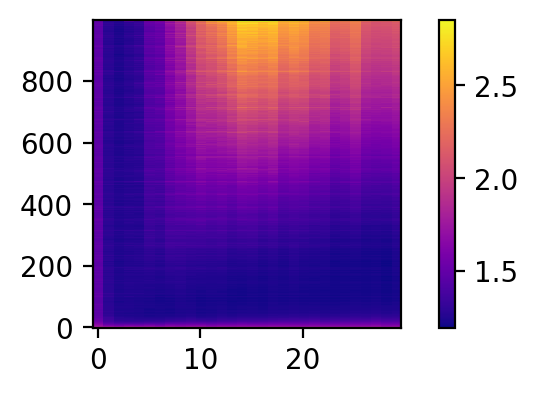

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(5, 2), dpi=200)
# Plot the heatmap
plt.imshow(np.array(HEAT).T, cmap='plasma', aspect=0.03, origin='lower',interpolation='none')
plt.colorbar()
plt.show()

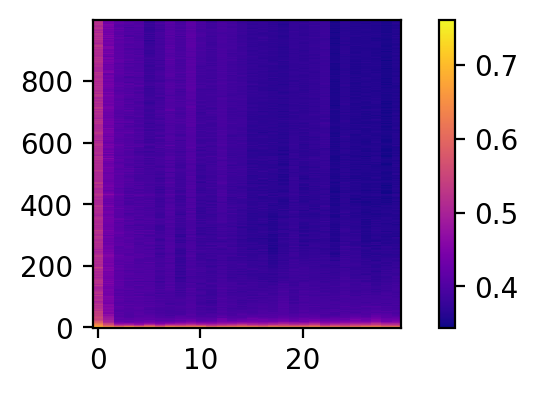

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(5, 2), dpi=200)
# Plot the heatmap
plt.imshow(1 - np.array(HEAT_vacc).T, cmap='plasma', aspect=0.03, origin='lower',interpolation='none')
plt.colorbar()
plt.show()

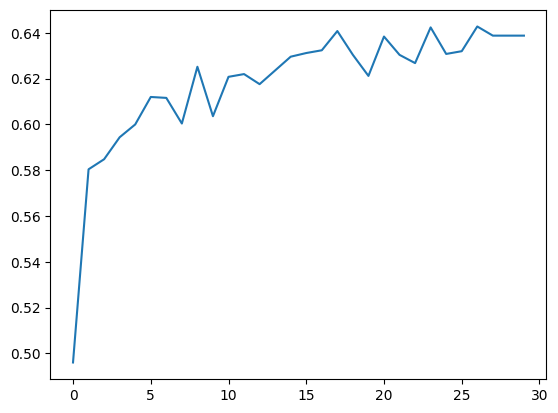

In [ ]:
plt.plot(np.array(HEAT_vacc)[:,300])

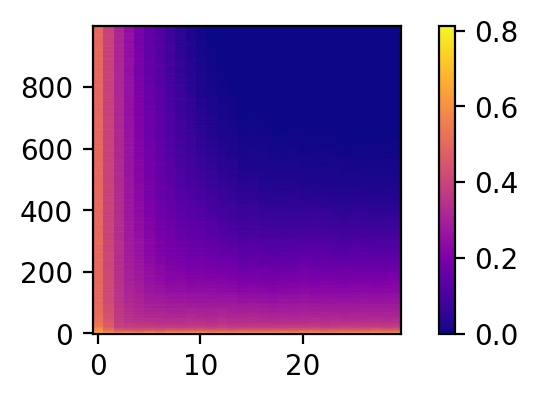

In [ ]:
import numpy as np


fig = plt.figure(figsize=(5, 2), dpi=200)
# Plot the heatmap
plt.imshow(1 - np.array(HEAT_tacc).T, cmap='plasma', aspect=0.03, origin='lower',interpolation='none')
plt.colorbar()
plt.show()

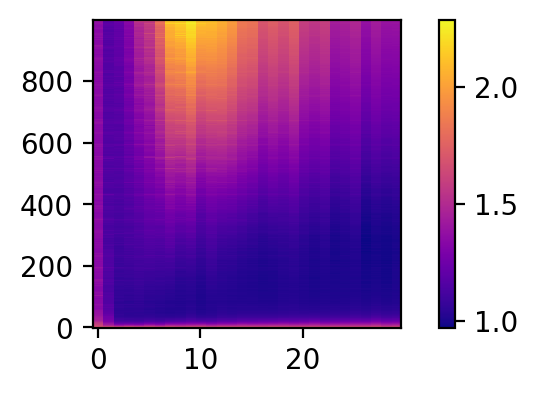

In [ ]:
import numpy as np


fig = plt.figure(figsize=(5, 2), dpi=200)
# Plot the heatmap
plt.imshow(np.array(HEAT).T, cmap='plasma', aspect=0.03, origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(5, 2), dpi=200)
# Plot the heatmap
plt.imshow(1 - np.array(HEAT_tacc).T, cmap='plasma', aspect=0.03, origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
# %pip install requests



import requests

token = "a84h6cor4jz23hhnz9xa68fgv1uniu"
user = "uqtm5t5tuqux6pwsenvfoi7xovxikc"

message = "COLAB computation finished"

requests.post("https://api.pushover.net/1/messages.json",
    data = {
        "token": token,
        "user": user,
        "message": message
    })

In [ ]:
!pwd

/content


In [ ]:

# drive.mount('/drive', force_remount=True)
# #%cd /gdrive/My Drive/LIBS_library/
# %cd /drive/My Drive/NTK_DD/final_code


HEAT = np.load('heat2000.npy')
#np.save('heat2000.npy', HEAT)

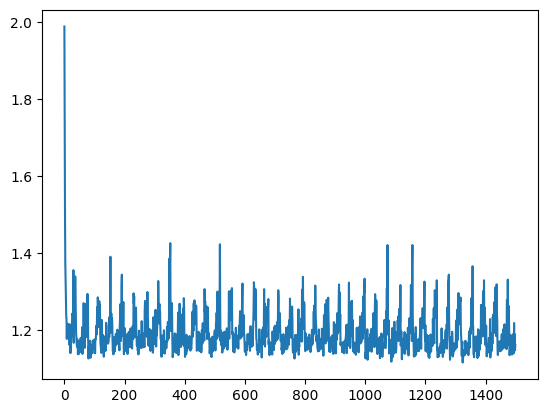

In [ ]:
plt.plot(HEAT[0])

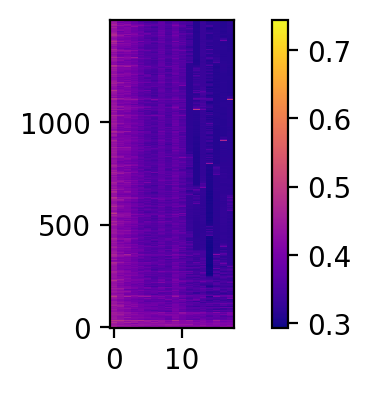

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(5, 2), dpi=200)
# Plot the heatmap
plt.imshow(1 - np.array(HEAT_vacc).T, cmap='plasma', aspect=0.03, origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
# import copy
# HEAT_first = copy.deepcopy(HEAT)

In [ ]:
if True:
  dataset = pd.DataFrame({"#parameters": mlp_param_counts, "TrainLoss": DD_train_loss, "TrainAcc": DD_train_acc, "TestLoss": DD_test_loss, "TestAcc": DD_test_acc, "TrainLinLoss": DD_lin_train_loss, "TrainLinAcc": DD_lin_train_acc, "TestLinLoss": DD_lin_test_loss, "TestLinAcc": DD_lin_test_acc, "DeltaFTrain": DD_delta_f_train, "DeltaFTest": DD_delta_f_test})
  dataset.to_pickle('l_1_ep_500_batch_128_lr_1_mom_0.9.pkl')

ValueError: ignored

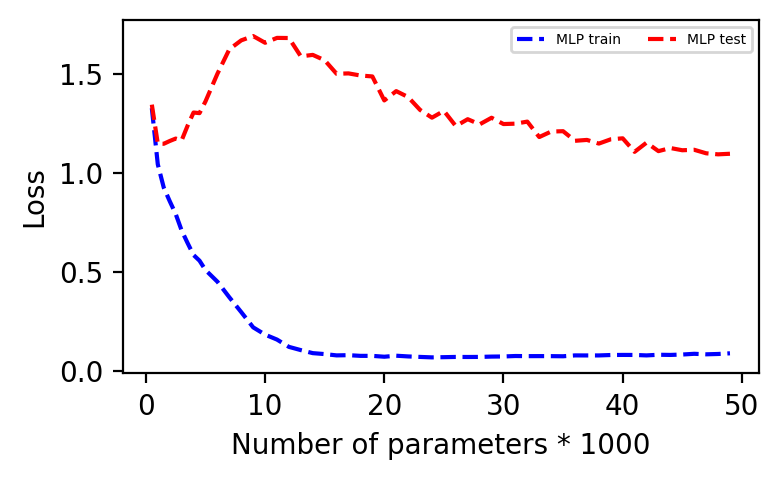

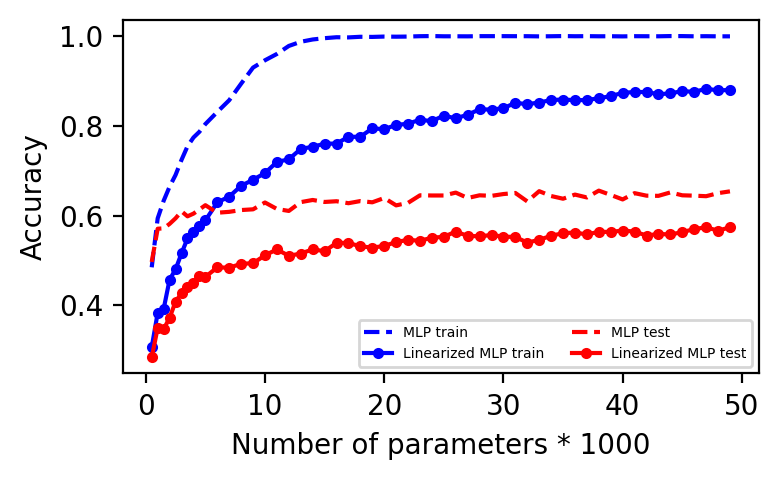

In [ ]:
if True:
  import pandas as pd
  df = pd.read_pickle('Looped_results_momentum_deltas.pkl')

  fig = plt.figure(figsize=[4,2.5], dpi=200)
  #N = data['x'].shape[0]
  x = df['#parameters']/1000
  plt.plot(x, df['TrainLoss'], 'b--', label='MLP train')# ; plt.fill_between(x, train_mean-train_err, train_mean+train_err, color='r', alpha=0.25)
  #plt.plot(x, df['TrainLinLoss'], 'b.-', label='Linearized MLP train')# ; plt.fill_between(x, test_mean-test_err, test_mean+test_err, color='r', alpha=0.25)
  plt.plot(x, df['TestLoss'], 'r--', label='MLP test')# ; plt.fill_between(x, test_mean-test_err, test_mean+test_err, color='r', alpha=0.25)
  #plt.plot(x, df['TestLinLoss'], 'r.-', label='Linearized MLP test')# ; plt.fill_between(x, test_mean-test_err, test_mean+test_err, color='r', alpha=0.25)
  #plt.plot([N,N],[0,mlp_test_risks.max()*1.1], 'k--', label="Interpolation threshold")
  plt.xlabel("Number of parameters * 1000") ; plt.ylabel("Loss") #; plt.legend(fontsize=6)
  #plt.ylim(None, np.array(test_log).max()*1.4)
  plt.legend(fontsize=5, ncol=2)
  #plt.xlim(0,100)

  plt.tight_layout() ; plt.show()
  fig.savefig("project.png", bb_inches = 'tight')

  fig = plt.figure(figsize=[4,2.5], dpi=200)
  #N = data['x'].shape[0]
  x = df['#parameters']/1000
  plt.plot(x, df['TrainAcc'], 'b--', label='MLP train')# ; plt.fill_between(x, train_mean-train_err, train_mean+train_err, color='r', alpha=0.25)
  plt.plot(x, df['TrainLinAcc'], 'b.-', label='Linearized MLP train')# ; plt.fill_between(x, test_mean-test_err, test_mean+test_err, color='r', alpha=0.25)
  plt.plot(x, df['TestAcc'], 'r--', label='MLP test')# ; plt.fill_between(x, test_mean-test_err, test_mean+test_err, color='r', alpha=0.25)
  plt.plot(x, df['TestLinAcc'], 'r.-', label='Linearized MLP test')# ; plt.fill_between(x, test_mean-test_err, test_mean+test_err, color='r', alpha=0.25)
  #plt.plot([N,N],[0,mlp_test_risks.max()*1.1], 'k--', label="Interpolation threshold")
  plt.xlabel("Number of parameters * 1000") ; plt.ylabel("Accuracy") #; plt.legend(fontsize=6)
  #plt.ylim(None, np.array(test_log).max()*1.4)
  plt.legend(fontsize=5, ncol=2)
  #plt.xlim(0,100)
  plt.tight_layout() ; plt.show()
  fig.savefig("project_acc.png",bb_inches = 'tight')

In [ ]:
if True:

  fig = plt.figure(figsize=[4,2.5], dpi=200)
  #N = data['x'].shape[0]
  x = df['#parameters']/1000
  plt.plot(x, abs(df['DeltaFTrain']), 'g--', label='Train data')# ; plt.fill_between(x, train_mean-train_err, train_mean+train_err, color='r', alpha=0.25)
  plt.plot(x, abs(df['DeltaFTest']), 'g.-', label='Test data')# ; plt.fill_between(x, test_mean-test_err, test_mean+test_err, color='r', alpha=0.25)
  # plt.plot(x, df['TestLoss'], 'r--', label='MLP test')# ; plt.fill_between(x, test_mean-test_err, test_mean+test_err, color='r', alpha=0.25)
  # plt.plot(x, df['TestLinLoss'], 'r.-', label='Linearized MLP test')# ; plt.fill_between(x, test_mean-test_err, test_mean+test_err, color='r', alpha=0.25)
  #plt.plot([N,N],[0,mlp_test_risks.max()*1.1], 'k--', label="Interpolation threshold")
  plt.xlabel("Number of parameters * 1000") ; plt.ylabel("MSE(f - f_lin)") #; plt.legend(fontsize=6)
  #plt.ylim(None, np.array(test_log).max()*1.4)
  plt.legend(fontsize=5, ncol=2)
  #plt.xlim(0,100)

  plt.tight_layout() ; plt.show()
  fig.savefig("l_1_ep_500_batch_128_lr_1_mom_0.9_deltas.png",bb_inches = 'tight')

In [ ]:
!pwd

/gdrive/My Drive/NTK_DD/final_code


In [ ]:
if True:
  #### Params statistics for Vanilla Stax
  from jax.tree_util import tree_leaves
  a = tree_leaves(params_init)
  W1 = a[0].shape
  print('W1 MEAN:' + str(np.mean(a[0])))
  print('W1 STD:' + str(np.std(a[0])))

  print('B1 MEAN:' + str(np.mean(a[1])))
  print('B1 STD:' + str(np.std(a[1])))

  print('W2 MEAN:' + str(np.mean(a[2])))
  print('W2 STD:' + str(np.std(a[2])))

  print('B2 MEAN:' + str(np.mean(a[3])))
  print('B2 STD:' + str(np.std(a[3])))

In [ ]:
if False:
  #### Params statistics for Neural Tangents Stax
  from jax.tree_util import tree_leaves
  w,b = tree_leaves(params_init)

  print('W MEAN:' + str(np.mean(w)))
  print('W STD:' + str(np.std(w)))

  print('B MEAN:' + str(np.mean(b)))
  print('B STD:' + str(np.std(b)))

## single complexity

In [ ]:



BATCH_SIZE = 256



#####################################################################
#####################################################################
# Get the full train dataset (for checking accuracy while training)
train_images = onp.array(data['x'])

train_labels = jnp.squeeze(jax.nn.one_hot(onp.array(data['y']), num_classes=10))
# Get full test dataset

test_images = onp.array(data['x_test'])
test_labels = jnp.squeeze(jax.nn.one_hot(onp.array(data['y_test']), num_classes=10))



num_train = train_images.shape[0]
num_complete_batches, leftover = divmod(num_train, BATCH_SIZE)
num_batches = num_complete_batches + bool(leftover)

def data_stream():
  rng = npr.RandomState(0)
  while True:
    perm = rng.permutation(num_train)
    for i in range(num_batches):
      batch_idx = perm[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
      yield train_images[batch_idx], train_labels[batch_idx]

def valid_data_stream():
  yield test_images, test_labels



def run_DD_loop_single(hidden_size, EPOCHS):
  valid_batches = valid_data_stream()
  batches = data_stream()

  #####################################################################
  #####################################################################
  # Vanila Stax
  # from jax.example_libraries import stax
  # nn_init, nn_apply = stax.serial(
  #     stax.Dense(hidden_size),
  #     stax.Relu,
  #     stax.Dense(10))
  ################################
  # Neural Tangents Stax




  # from jax import tree_map
  # #params_init = tree_map(lambda x: x/5, params_init)

  # Get the optimizer objects

  opt_state = opt_init(params_init)
  lin_opt_state = opt_init(params_init)

  # Initial rng key for the data generator
  key = random.PRNGKey(111+trial)

  # Lists to record loss and accuracy for each epoch
  training_loss = []
  validation_loss = []
  training_accuracy = []
  validation_accuracy = []
  lin_training_loss = []
  lin_validation_loss = []
  lin_training_accuracy = []
  lin_validation_accuracy = []

  # Training
  for i in range(EPOCHS):
      num_train_batches = len(train_images) // BATCH_SIZE
      num_valid_batches = len(test_images) // BATCH_SIZE

      # Lists to store loss and accuracy for each batch
      train_batch_loss, train_batch_acc = [], []
      valid_batch_loss, valid_batch_acc = [], []
      lin_train_batch_loss, lin_train_batch_acc = [], []
      lin_valid_batch_loss, lin_valid_batch_acc = [], []
      delta_tr, delta_te = [], []

      # Key to be passed to the data generator for augmenting
      # training dataset
      key, subkey = random.split(key)



      # Training
      for step in range(num_train_batches):
          batch_data = next(batches)
          loss_value, acc, opt_state = train_step(step, opt_state, batch_data)
          lin_loss_value, lin_acc, lin_opt_state = lin_train_step(step, lin_opt_state, batch_data)

          # if i == 0:
          #   if step == 0:
          #     delta_first_tr = deltas(opt_state,lin_opt_state, train_images)
          #     delta_first_te = deltas(opt_state,lin_opt_state, test_images)

          train_batch_loss.append(loss_value)
          train_batch_acc.append(acc)
          lin_train_batch_loss.append(lin_loss_value)
          lin_train_batch_acc.append(lin_acc)

      # Evaluation on validation data

      valid_loss_value, valid_acc = test_step(opt_state, test_images, test_labels)
      valid_batch_loss.append(valid_loss_value)
      valid_batch_acc.append(valid_acc)
      lin_valid_loss_value, lin_valid_acc = lin_test_step(lin_opt_state, test_images, test_labels)
      lin_valid_batch_loss.append(lin_valid_loss_value)
      lin_valid_batch_acc.append(lin_valid_acc)

      # Loss for the current epoch
      epoch_train_loss = onp.mean(train_batch_loss)
      epoch_valid_loss = onp.mean(valid_batch_loss)
      lin_epoch_train_loss = onp.mean(lin_train_batch_loss)
      lin_epoch_valid_loss = onp.mean(lin_valid_batch_loss)

      # Accuracy for the current epoch
      epoch_train_acc = onp.mean(train_batch_acc)
      epoch_valid_acc = onp.mean(valid_batch_acc)
      lin_epoch_train_acc = onp.mean(lin_train_batch_acc)
      lin_epoch_valid_acc = onp.mean(lin_valid_batch_acc)

      delta_f_train = deltas(opt_state,lin_opt_state, train_images)
      delta_f_test = deltas(opt_state,lin_opt_state, test_images)
      delta_tr.append(delta_f_train)
      delta_te.append(delta_f_test)
      #delta
  # delta_f_train = delta_first_tr
  # delta_f_test = delta_first_te




      print(f"epoch #: {i} loss: {epoch_train_loss:.3f}   acc: {epoch_train_acc:.3f}  valid_loss: {epoch_valid_loss:.3f}  valid_acc: {epoch_valid_acc:.3f}  lin loss: {lin_epoch_train_loss:.3f}  lin acc: {lin_epoch_train_acc:.3f}  lin valid_loss: {lin_epoch_valid_loss:.3f}  lin valid_acc: {lin_epoch_valid_acc:.3f}  delta f train: {delta_f_train:.3f}  delta f test: {delta_f_test:.3f}")
  return epoch_train_loss, epoch_train_acc, epoch_valid_loss, epoch_valid_acc, lin_epoch_train_loss, lin_epoch_train_acc, lin_epoch_valid_loss, lin_epoch_valid_acc, delta_f_train, delta_f_test, delta_tr, delta_te


In [ ]:
EPOCHS = 1000
learning_r = 1

hidden_size = 310


import pandas as pd
trials = 1
mlp_param_counts = []

DD_train_loss, DD_train_lin_loss = [], []
DD_test_loss, DD_test_lin_loss = [], []
DD_train_acc, DD_train_lin_acc = [], []
DD_test_acc, DD_test_lin_acc = [], []
DD_lin_train_loss, DD_lin_train_acc = [], []
DD_lin_test_loss, DD_lin_test_acc = [], []
DD_delta_f_test, DD_delta_f_train = [], []

for trial in range(trials):
  nn_init, nn_apply, _ = stax.serial(
    stax.Dense(hidden_size),
    stax.Relu(),
    stax.Dense(10))


  #opt_init, opt_update, get_params = optimizers.adam(step_size=LEARNING_RATE)
  opt_init, opt_update, get_params = optimizers.momentum(learning_r, 0.9)

  output_shape, params_init = nn_init(random.PRNGKey(111+trial), input_shape=(-1, 40))
  f_lin = nt.linearize(nn_apply, params_init)

  epoch_train_loss, epoch_train_acc, epoch_valid_loss, epoch_valid_acc, lin_epoch_train_loss, lin_epoch_train_acc, lin_epoch_valid_loss, lin_epoch_valid_acc, delta_f_train, delta_f_test, delta_tr, delta_te= run_DD_loop_single(hidden_size, EPOCHS)


#dataset = pd.DataFrame({"TrainLoss": DD_train_loss, "TrainAcc": DD_train_acc, "TestLoss": DD_test_loss, "TestAcc": DD_test_acc, "TrainLinLoss": DD_lin_train_loss, "TrainLinAcc": DD_lin_train_acc, "TestLinLoss": DD_lin_test_loss, "TestLinAcc": DD_lin_test_acc, "DeltaFTrain": DD_delta_f_train, "DeltaFTest": DD_delta_f_test})
#dataset.to_pickle('single_run.pkl')

epoch #: 0 loss: 2.104   acc: 0.218  valid_loss: 1.871  valid_acc: 0.268  lin loss: 2.107  lin acc: 0.217  lin valid_loss: 1.880  lin valid_acc: 0.262  delta f train: 0.000  delta f test: 0.000
epoch #: 1 loss: 1.779   acc: 0.307  valid_loss: 1.743  valid_acc: 0.316  lin loss: 1.793  lin acc: 0.305  lin valid_loss: 1.760  lin valid_acc: 0.314  delta f train: 0.000  delta f test: 0.000
epoch #: 2 loss: 1.689   acc: 0.348  valid_loss: 1.683  valid_acc: 0.350  lin loss: 1.706  lin acc: 0.347  lin valid_loss: 1.701  lin valid_acc: 0.339  delta f train: 0.000  delta f test: 0.000
epoch #: 3 loss: 1.632   acc: 0.374  valid_loss: 1.646  valid_acc: 0.351  lin loss: 1.653  lin acc: 0.372  lin valid_loss: 1.667  lin valid_acc: 0.348  delta f train: 0.000  delta f test: 0.000
epoch #: 4 loss: 1.592   acc: 0.397  valid_loss: 1.608  valid_acc: 0.385  lin loss: 1.615  lin acc: 0.394  lin valid_loss: 1.635  lin valid_acc: 0.378  delta f train: 0.000  delta f test: 0.000
epoch #: 5 loss: 1.549   acc: 

In [ ]:
delta_tr

[DeviceArray(0.02288646, dtype=float32)]

$-\frac{\pi}{2}<x,y\leq\frac{\pi}{2}:\Theta\left(x,y\right)=\sum_{n\in\mathbb{Z}}a_{n}e^{in\left(x-y\right)}$

$\begin{array}{c}
-\frac{\pi}{2}<x_{i},y_{i}\leq\frac{\pi}{2}:\\
\Theta_{R}\left(x,y\right)=a_{R}+c_{R}\sum_{\vec{n}\in\mathbb{Z}^{d}/\left\{ 0\right\} }\frac{\cos\left(\vec{n}\cdot\left(\vec{x}-\vec{y}\right)\right)}{\left|\vec{n}\right|^{d+1}}\\
a_{R},c_{R}\sim2
\end{array}$

In [ ]:
if True:

  fig = plt.figure(figsize=[4,2.5], dpi=200)
  #N = data['x'].shape[0]
  x = np.linspace(0, 199, num=200, endpoint=True)
  plt.plot(x, abs(delta_tr), 'g--', label='Train data')# ; plt.fill_between(x, train_mean-train_err, train_mean+train_err, color='r', alpha=0.25)
  plt.plot(x, abs(delta_te), 'g.-', label='Test data')# ; plt.fill_between(x, test_mean-test_err, test_mean+test_err, color='r', alpha=0.25)
  # plt.plot(x, df['TestLoss'], 'r--', label='MLP test')# ; plt.fill_between(x, test_mean-test_err, test_mean+test_err, color='r', alpha=0.25)
  # plt.plot(x, df['TestLinLoss'], 'r.-', label='Linearized MLP test')# ; plt.fill_between(x, test_mean-test_err, test_mean+test_err, color='r', alpha=0.25)
  #plt.plot([N,N],[0,mlp_test_risks.max()*1.1], 'k--', label="Interpolation threshold")
  plt.xlabel("epoch") ; plt.ylabel("MSE(f - f_lin)") #; plt.legend(fontsize=6)
  #plt.ylim(None, np.array(test_log).max()*1.4)
  plt.legend(fontsize=5, ncol=2)
  #plt.xlim(0,100)

  plt.tight_layout() ; plt.show()
  #fig.savefig("l_1_ep_500_batch_128_lr_1_mom_0.9_deltas.png",bb_inches = 'tight')

TypeError: ignored

<Figure size 800x500 with 0 Axes>

In [ ]:
if True:
  import time
  num_epochs = 500
  batch_size = 128
  hidden_size = 10

  def run_training_loop(num_epochs, opt_state, lin_opt_state):
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss, test_loss, train_lin_loss, deltas = [], [], [], [], [], []

    # # Get the initial set of parameters


    # # Get initial accuracy after random init
    # train_acc = accuracy(params, train_images, train_labels)
    # test_acc = accuracy(params, test_images, test_labels)
    # log_acc_train.append(train_acc)
    # log_acc_test.append(test_acc)

    nn_init, nn_apply, _ = stax.serial(
      stax.Dense(hidden_size),
      stax.Relu(),
      stax.Dense(10))


    #opt_init, opt_update, get_params = optimizers.adam(step_size=LEARNING_RATE)
    opt_init, opt_update, get_params = optimizers.momentum(learning_r, 0.9)

    output_shape, params_init = nn_init(random.PRNGKey(111+trial), input_shape=(-1, 40))
    f_lin = nt.linearize(nn_apply, params_init)

    params = get_params(opt_state)
    lin_params = get_params(lin_opt_state)


    ind_step = 0
    #epoch
    for epoch in range(num_epochs):
      start_time = time.time()
      i=0
      for batch in make_batches(train_images, train_labels, batch_size):
        x, y = batch
        params = get_params(opt_state)
        opt_state = opt_update(i, grad_loss(params, x, y), opt_state)

        lin_params = get_params(lin_opt_state)
        lin_opt_state = opt_update(i, grad_lin_loss(lin_params, x, y), lin_opt_state)

        ind_step += 1
        i += 1
      epoch_time = time.time() - start_time
      epoch_time = time.time() - start_time
      tr_loss = loss(f(params, x), y)
      tr_lin_loss = loss(f_lin(lin_params, x), y)
      delta_train = deltas(opt_state,lin_opt_state, train_images)
      delta_test = deltas(opt_state,lin_opt_state, test_images)

      train_lin_loss.append(tr_lin_loss)
      train_loss.append(tr_loss)
      deltas_test.append(delta_test)
      deltas_train.append(delta_train)

      #params_out, opt_state_out, loss_out = update(params, test_images, test_labels, opt_state)##only for epoch-wise DD
      #test_loss.append(loss_out)## only for epoch-wise DD
      print("Epoch {} | T: {:0.2f} | Train loss: {:0.3f} | Train lin loss: {:0.3f}".format(epoch+1, epoch_time, tr_loss, tr_lin_loss))
    return train_loss, train_lin_loss, deltas_test, deltas_train


  train_loss, train_lin_loss, deltas_test, deltas_train = run_training_loop(num_epochs, opt_state, lin_opt_state)

NameError: ignored